Purpose of this notebook

Establish and demonstrate non-stationarity in SPI before any forecasting or benchmarking.

This notebook answers:

- Is SPI stationary?
- How has its distribution changed over time?
- Why do we need temporal splits?

## supplementary

In [1]:
import src
print(src)


<module 'src' from 'D:\\14999580\\src\\__init__.py'>


In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd()
sys.path.append(str(project_root))


In [4]:
DATA_DIR = Path("data/curated")
DATA_DIR

WindowsPath('data/curated')

## Data processing and SPI computation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.dataloader import load_precipitation
from src.indices.spi import compute_spi


In [6]:
GAUGE_ID = "03004"   # choose one and stick to it for this notebook


In [7]:
precip = load_precipitation(GAUGE_ID)
precip.head()

,year,month,day,prcp(mm/day)
0,1980,1,1,0.00
1,1980,1,2,0.00
2,1980,1,3,0.00
3,1980,1,4,0.07
4,1980,1,5,0.29


In [8]:
spi3 = compute_spi(precip, scale=3)
spi6 = compute_spi(precip, scale=6)


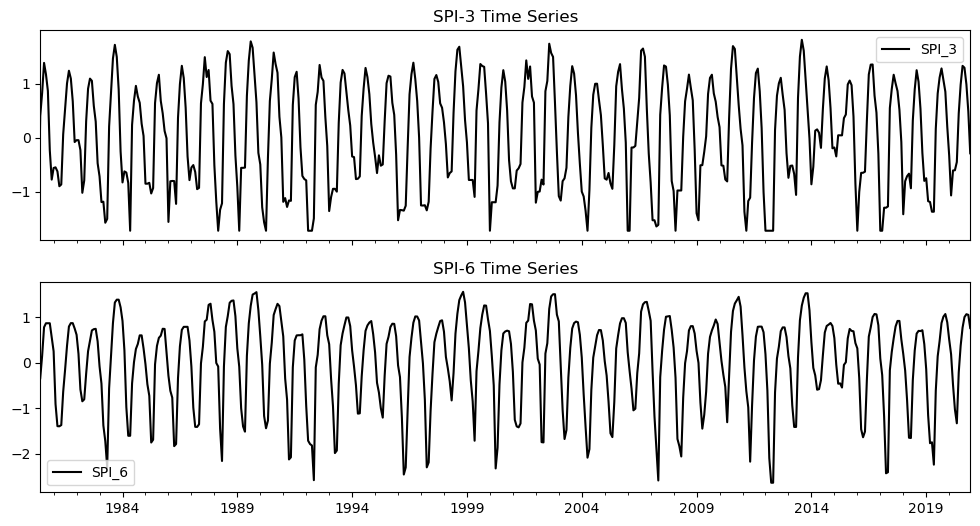

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

spi3.plot(ax=ax[0], color="black")
ax[0].set_title("SPI-3 Time Series")

spi6.plot(ax=ax[1], color="black")
ax[1].set_title("SPI-6 Time Series")

plt.show()


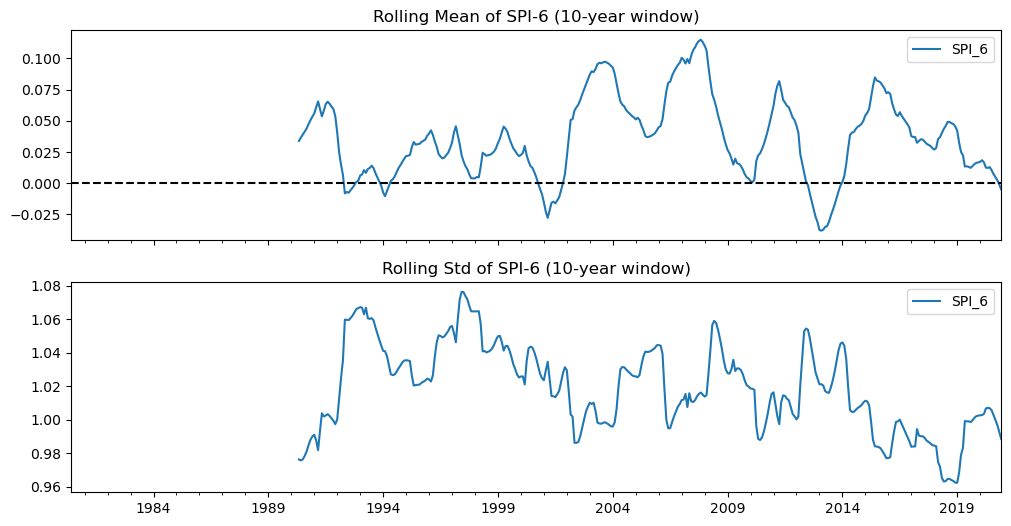

In [12]:
window = 120  # 10 years (monthly)

rolling_mean = spi6.rolling(window).mean()
rolling_std = spi6.rolling(window).std()

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

rolling_mean.plot(ax=ax[0])
ax[0].set_title("Rolling Mean of SPI-6 (10-year window)")
ax[0].axhline(0, color="k", linestyle="--")

rolling_std.plot(ax=ax[1])
ax[1].set_title("Rolling Std of SPI-6 (10-year window)")

plt.show()


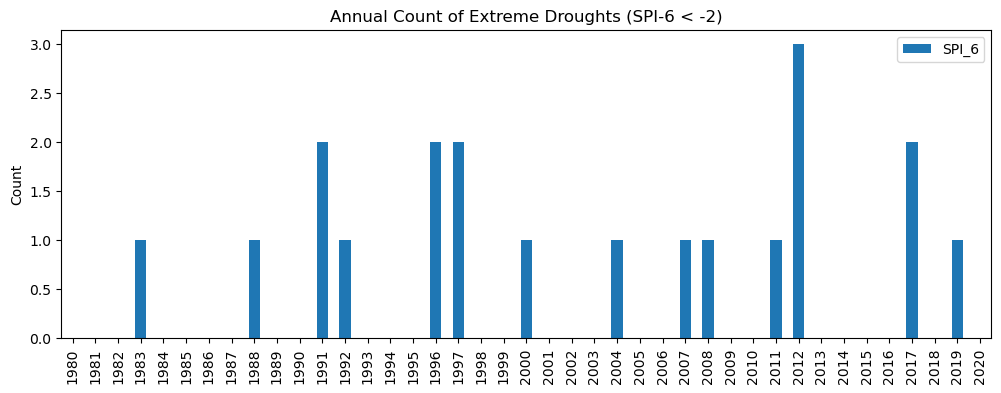

In [13]:
extreme = spi6[spi6 < -2]

extreme_count = extreme.groupby(extreme.index.year).count()

extreme_count.plot(kind="bar", figsize=(12,4))
plt.title("Annual Count of Extreme Droughts (SPI-6 < -2)")
plt.ylabel("Count")
plt.show()


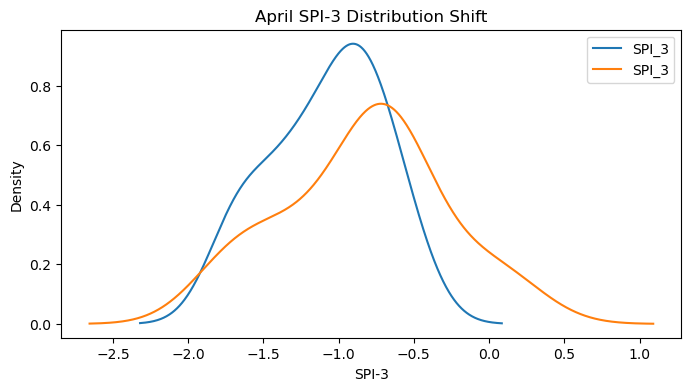

In [18]:
spi_apr = spi3[spi3.index.month == 4]

early = spi_apr[spi_apr.index.year <= 2000]
late  = spi_apr[spi_apr.index.year > 2000]

fig, ax = plt.subplots(figsize=(8, 4))

early.plot(kind="kde", ax=ax, label="April SPI-3 (≤ 2000)")
late.plot(kind="kde", ax=ax, label="April SPI-3 (> 2000)")

ax.set_xlabel("SPI-3")
ax.set_ylabel("Density")
ax.set_title("April SPI-3 Distribution Shift")
ax.legend()

plt.show()
